# PVNet 6D Pose PipeLine Demo

## Introduction

In this notebook we'll be performing a quick version of the 6D pose estimation solution implemented by this project. The process is similar to the flow contained in an iteration of the pipeLine.py evalModels function.

## Contributions

* Propose a novel framework for 6D pose estimation using a pixel-wise voting network (PVNet), which learns a vector-field representation for robust 2D keypoint localization and naturally deals with occlusion and truncation.

* Propose to utilize an uncertainty-driven PnP algorithm to account for uncertainties in 2D keypoint localizations, based on the dense predictions from PVNet.

* Demonstrate significant performance improvements of our approach compared to the state of the art on benchmark datasets (ADD: 86.3% vs. 79% and 40.8% vs. 30.4% on LINEMOD and OCCLUSION, respectively). 

* Create a new dataset (Truncation LINEMOD) for evaluation on truncated objects.

* Real time pose estimation with 25 fps.

## PVNet Architecture

![PVNet Architecture](img/pvnet.png "PVNet Architecture")

## Proposed approch [PVNet]

- Two stage pipeline Methods:
1. First detect 2D object keypoints using CNN's features.
2. Compute 6D pose parameters using the PnP algorithm.

- **Innovation for PVNet**:  is in a new representation for 2D object keypoints as well as a modified PnP algorithm for pose estimation.

    - PVNet method uses a Pixel-wise Voting Network (PVNet) to detect 2D keypoints in a RANSAC-like fashion, which robustly handles occluded and truncated objects. 
    - The RANSAC-based voting also gives a spatial probability distribution of each keypoint, allowing us to estimate the 6D pose with an uncertainty-driven PnP.

## Data Format
* Images: RGB images (H, W, 3)
* Mask: mask imgage (H, w, 1)
* Labels: .txt file 
    * 9 bbox 2d pixel location of a set of 3d keypoints.
    * Format: {Object tag}{x1}{y1}......{x9}{y9}.
    * Values: [0-1] given relative coordinate on image ex: x1=0.1, y1=0.5, img=[640,480] => pixel(64,240)
* 3D keypoint: .txt file
    * File containing corresponding keypoint locations in 3d coordinate system (for Pnp).

## Read image and labels

RGB Image Shape: (480, 640, 3)
Keypoint Labels: ['6.686142628874398586e-01', '7.263400377314979117e-01', '5.493648993389658175e-01', '9.312443868540029035e-01', '5.769284322293616318e-01', '7.881035621388378098e-01', '6.407135761041395927e-01', '8.899895375398150232e-01', '5.877399934822387095e-01', '7.999863116729838408e-01', '5.829383316205479781e-01', '9.211855263900207147e-01', '6.211462113671539775e-01', '7.124319717426675913e-01', '6.357183510471959842e-01', '8.133651672576241998e-01', '6.086036276270714307e-01', '8.212373153805835324e-01\n']
# Keypoint Labels: 18


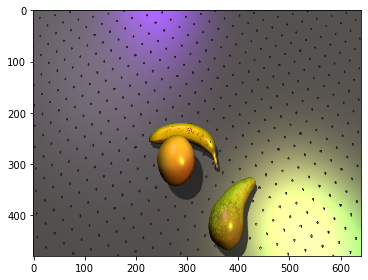

In [52]:
import sys

import tensorflow as tf, numpy as np, matplotlib.pyplot as plt, random, math, statistics, os
from skimage.io import imshow
import data
import numpy as np

class_name = 'pear'

image, labels, mask, ch, val = data.getDataSplitImage(True, modelClass=class_name) # Loading a random image from the validation data set

print("RGB Image Shape: " + str(image.shape)) # an rgb image of dimensions 480 x 640 x 3
print("Keypoint Labels: "+ str(labels)) # a labels file detailing x, y coordinates for 9 2d keypoints on our loaded image
print("# Keypoint Labels: "+ str(len(labels))) # a labels file detailing x, y coordinates for 9 2d keypoints on our loaded image

def showImage(img): # displays image using plt
	plt.figure()
	imshow(np.squeeze(img))
	plt.show()
    
showImage(image)

In [53]:
ch

['4294.png', '4294.png', '4294.txt']

In [54]:
img_id = ch[0].split('.png')
int(img_id[0])

4294

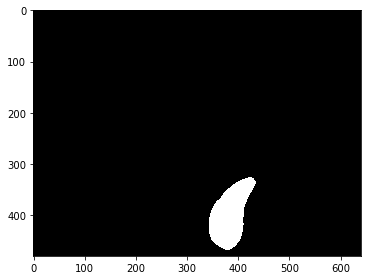

In [55]:
showImage(mask)

In [56]:
# mask = mask /255.0

In [57]:
mask.max()

255


We now have our image, and a list containing info for the corresponding 2d bounding box keypoints. Let's load the models we'll be using to generate our predictions for unit vector and class outputs.

## Predicte unit vector and class output
- Assuming **C** classes of objects and **K** keypoints for each class, PVNet takes as input the H × W × 3 image
    * Class output: H × W × (C+1)
    * Unit vector: H × W × (K*2*C)

Vector Prediction shape: (480, 640, 18)
Class Prediction shape: (480, 640, 1)


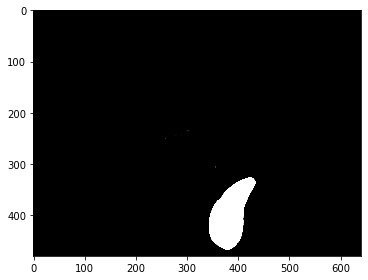

In [58]:
import models


nnInput = np.array([image])

# loading our model to predict unit vectors per pixel per keypoint on image
vecModel = models.stvNetNew(outVectors = True, outClasses = False)
vecModel.load_weights(f'models/stvNet_new_coords_{class_name}') # loading weights for standard labels model
vecModel.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.Huber())

# loading our class model for image segmentation
classModel = models.uNet(outVectors = False, outClasses = True)
classModel.load_weights(f'models/uNet_classes_{class_name}')
classModel.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.BinaryCrossentropy())

vecPred = vecModel.predict(nnInput)[0]
classPred = classModel.predict(nnInput)[0]

print("Vector Prediction shape: " + str(vecPred.shape))
print("Class Prediction shape: " + str(classPred.shape))
showImage(classPred) # let's see our class prediction output

In [59]:
classPred.max()

1.0

## Model Prediction Results

We can see that our vector prediction has a shape that matches our photo dimensions in width and height, but has 18 values for each pixel. Each value represents an x or y component for our unit vector predictions for each of the 9 keypoints we are looking for.

Our class prediction has (hopefully) found the pixels associated with our object of interest. We can now filter for these pixels and use the associated vector predictions for our ransac voting process.

In [60]:
population = np.where(classPred > .9)[:2] #.9
population = list(zip(population[0], population[1]))

print(len(population)) # the number of class pixels found

7588


## RanSaC Voting

The goal of RanSaC voting algorithm:
- **Input:** the predictions on the pixels of interest.
- **Output:** generate a list of hypotheses, and an associated weight for each hypothesis (which indicates how well the prediction 'fits' the rest of the data).

1. Take two pixels from our population at random. 
2. For each keypoint, find the intersection of the lines given by the unit vector predictions for each keypoint, which will be used as our hypothesis. 

    - This process also involves a fairly intimidating-looking if statement, which checks that our hypothesis was generated on the correct side  of the two queried pixels according to their unit vector predictions.

- We then see how well this hypothesis aligns with the rest of the population. 

3. For every other pixel of interest, we see find the unit vector between our hypothesis and the pixel, and see how similar the real unit vector is to the unit vector predicted by our vector model. 

    - Taking the dot product of the two unit vectors, which will have a value between 1 and -1. 
        - 1 for unit vectors pointing in the same direction. 
        - -1 for the opposite direction.

    - If this value is above a certain threshold, in this case .99, increment the weight value for the hypothesis. 
    - Use this weight value to determine which hypotheses best fit the rest of the population data.
        - Higher voting score means that a hypothesis is more confident as it coincides with more predicted directions.
        
    - The resulting hypotheses characterize the spatial probability distribution of a keypoint in the image. 
    - Finally, the mean and the covariance for a keypoint are estimated.

In [61]:
def ransacVal(y1, x1, v2): # dot product of unit vectors to find cos(theta difference)
	v2 = v2 / np.linalg.norm(v2)
	
	return y1 * v2[1] + x1 * v2[0]

hypDict = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: []}

for n in range(50): #take two pixels, find intersection of unit vectors
    #print(n)
    p1 = population.pop(random.randrange(len(population)))
    v1 = vecPred[p1[0]][p1[1]]
    p2 = population.pop(random.randrange(len(population)))
    v2 = vecPred[p2[0]][p2[1]]
    print(p1, p2)
    print(v1, v2)
    for i in range(9): # find lines intersection, use as hypothesis
        m1 = v1[i * 2 + 1] / v1[i * 2]
        m2 = v2[i * 2 + 1] / v2[i * 2]
        b1 = p1[0] - p1[1] * m1
        b2 = p2[0] - p2[1] * m2
        x = (b2 - b1) / (m1 - m2)
        y = m1 * x + b1
        if (y >= p1[0] != v1[i * 2 + 1] < 0 or x >= p1[1] != v1[i * 2] < 0 or y >= p2[0] != v2[i * 2 + 1] < 0 or x >= p2[1] != v2[i * 2] < 0) or not (m1 - m2): # check if line intersection takes place according to unit vector directions
            continue
        print(y, x)
        weight = 0
        for voter in population: # voting for fit of hypothesis
            yDiff = y - voter[0]
            xDiff = x - voter[1]

            mag = math.sqrt(yDiff ** 2 + xDiff ** 2)
            vec = vecPred[voter[0]][voter[1]][i * 2: i * 2 + 2]

            if ransacVal(yDiff / mag, xDiff / mag, vec) > .99:
                weight += 1
        hypDict[i].append(((y, x), weight))

    population.append(p1)
    population.append(p2)
    print("--------------------")

print("Coordinate hypotheses and weights: " + str(hypDict[0]))
print("# Coordinate hypotheses and weights: " + str(len(hypDict[0])))

(364, 392) (417, 390)
[ 0.9219574  -0.41446587 -0.46761122  0.89711267 -0.8471135   0.49623317
  0.25534162  0.938099   -0.6129987   0.75820845 -0.26452094  0.9616415
  0.25848803 -1.0394933   0.48156703  0.82792467 -0.06503494  0.9682    ] [ 4.5332789e-01 -9.2610180e-01 -8.1497896e-01  5.9311306e-01
 -4.6418869e-01 -9.3715292e-01  8.6694086e-01  4.7118798e-01
 -3.8097799e-01 -9.3335295e-01 -5.8838826e-01  8.0427396e-01
  8.5847110e-02 -1.0268021e+00  5.4507983e-01 -8.7991989e-01
 -8.8869863e-05 -9.9536514e-01]
350.1992483074778 422.69904000881047
447.04791757485043 348.71208325073934
376.82772465231636 370.10195026112837
427.47779527463376 409.2780517344803
383.4249279607432 376.2952740522515
444.55466589268417 369.84164175101273
349.27130754264795 395.6625444689548
389.6690731675227 406.930560189549
393.805756963814 389.9979182405537
--------------------
(335, 410) (449, 399)
[ 0.83968586  0.52475053 -0.4507978   0.8927477  -0.6863344   0.7134837
 -0.03030851  0.98045754 -0.55777407 

381.7131561509957 375.35314561615985
462.127456400837 364.900623905315
339.4508279973627 397.0240085082334
389.6240940605903 406.4981827794413
378.72926483479637 392.0091551476997
--------------------
(349, 403) (362, 418)
[ 0.99521685 -0.0609294  -0.51427954  0.8846368  -0.74191135  0.6199278
  0.02207924  0.9768278  -0.62614465  0.74574274 -0.35174212  0.97030234
 -0.57856166 -0.8345304   0.06348369  0.9759226  -0.30704188  0.9304039 ] [ 0.61101156 -0.788623   -0.65198785  0.77372426 -1.0043525   0.28675
 -0.1519188   0.9675546  -0.8963344   0.45175916 -0.52348536  0.84053946
 -0.72089714 -0.7456494  -0.39436528  0.8915131  -0.67447656  0.7217253 ]
347.3885905836952 429.32065578951324
448.32252866390616 345.25930308540006
375.25286628234113 371.58134348598395
443.8756604935079 405.1444746485707
384.6437383685595 373.0726072478408
437.7334704096729 370.8334280988345
340.1103886503355 396.8370272521941
389.89523563162766 405.6602317468902
393.9095787381807 388.1794237593947
-----------

391.4687091953977 405.64609790495217
393.5023657228133 387.25463920132125
--------------------
(444, 373) (415, 356)
[ 0.46435362 -0.8817472  -0.9895897   0.08380553 -0.05736175 -1.0684743
  0.8834197  -0.42591512  0.0828855  -1.0401559   0.05679608 -0.582279
  0.25411344 -1.039172    0.5462575  -0.8931146   0.3149686  -0.959223  ] [ 0.7627771  -0.7039611  -0.18094037  0.9909841   0.31943217 -0.9643321
  0.9713284   0.19738103  0.54102856 -0.869782    0.5175326   0.85835505
  0.52154034 -0.9065438   0.89247084 -0.46573794  0.8275412  -0.5665743 ]
357.0524041924426 418.7891223450368
445.91775418539845 350.3548388106337
374.88115222480246 369.28930890929365
426.02903703502164 410.27480348585397
379.3935935148811 378.14820321220753
443.30758898277827 373.06753846355866
342.16579248138214 397.9019789613044
388.3735882153678 407.02289304353013
391.5754698004391 390.21401700089893
--------------------
(360, 372) (354, 391)
[ 1.0181619  -0.23689088 -0.28527492  0.93248606 -0.12970354  0.92988

389.924109562412 407.16382547365555
390.68442127389426 388.51625299514563
--------------------
(405, 401) (337, 417)
[ 0.41982478 -0.9387523  -0.7968022   0.6207836  -0.75540084 -0.6770783
  0.3662357   0.90313226 -0.77424765 -0.65810627 -0.63165057  0.7901159
 -0.0474645  -1.0627432   0.38079828 -0.95174134 -0.7179375  -0.7034494 ] [ 0.6830476   0.67886114 -0.5328975   0.8466488  -0.77315825  0.6367198
 -0.10993523  0.99224657 -0.6459534   0.72961295 -0.42762962  0.91198355
 -0.96314645  0.17595704 -0.20456979  0.93916667 -0.42411038  0.8868443 ]
346.9152799735931 426.9764007421109
445.9717268359422 348.4110436168123
376.42814587047 369.12303318442866
421.3970795312715 407.6492982001745
383.5611620552022 375.7776757020267
453.05847648551963 362.58011261550524
340.44977720874704 398.11704210701066
398.4816677884925 403.6080298011358
393.9785070647811 389.7515106857844
--------------------
(452, 397) (402, 347)
[ 0.2965304  -0.98958695 -1.018073   -0.13577452 -0.30571678 -0.9989333
  0.

429.27093205601534 411.39049197810897
442.49260368344585 372.38979687646395
346.73683129456185 393.8766384204761
390.9944389213214 408.7270248766072
390.44277805798663 385.12362295703167
--------------------
(408, 344) (386, 389)
[ 0.856148   -0.62274927  0.19631863  0.95629627  0.6281357  -0.85028327
  0.8975601   0.288155    0.8034678  -0.5462303   0.6240357   0.72052455
  0.6328677  -0.80493414  0.97713923 -0.30474874  1.0040989  -0.30309317] [ 0.7365623  -0.722069   -0.5365986   0.8363609  -0.9171241  -0.43045488
  0.41513607  0.86123514 -0.9838725  -0.19039795 -0.26576388  0.9542603
  0.1872209  -1.0404876   1.0008922   0.20874356  0.05793056  1.0041155 ]
344.4042474150225 431.4306573952846
444.46926986541007 351.4867980147464
375.9810181992707 367.6536056333552
429.1196972883326 409.78473195591886
384.09599956559646 379.1611673383474
441.96239569253976 373.4143325499351
340.30833941988635 397.2215792921682
389.19205680838644 404.3053472795182
394.27241519906613 389.47727961370083

## Data Preparation

Now we have a dictionary with a key / value pair for each keypoint. Each value contains a list of coordinates, each with an associated weight indicating the 'fit' of that keypoint to the rest of the popluation.

Better performance can be achieved by pruning some of the outlying values from these hypotheses, one method is to find the mean, and standard deviation values for each keypoint, and prune those that lie outside a certain range.

In [62]:
def pruneHypsStdDev(hypDict, m = 2): # prune generated hypotheses using mean and stdDev
	for key, hyps in hypDict.items():
		yVals, xVals = [x[0][0]for x in hyps], [x[0][1]for x in hyps]
		yMean, xMean = statistics.mean(yVals), statistics.mean(xVals)
		yDev, xDev = statistics.pstdev(yVals) * m, statistics.pstdev(xVals) * m
		hypDict[key] = [x for x in hyps if not determineOutlier(x[0], yMean, yDev, xMean, xDev)]
        
def determineOutlier(input, yMean, yDev, xMean, xDev):
	return abs(input[0] - yMean) > yDev or abs(input[1] - xMean) > xDev
        
pruneHypsStdDev(hypDict)

In [63]:
print("# Coordinate hypotheses and weights: " + str(len(hypDict[0])))

# Coordinate hypotheses and weights: 44


Now we need our keypoints to use to solve our PnP problem. This can be done my taking a weighted average of the hypotheses for each of the keypoints.

In [64]:
def getMean(hypDict): # get weighted average of coordinates
	meanDict = {}
	for key, hyps in hypDict.items():
		xMean = 0
		yMean = 0
		totalWeight = 0
		for hyp in hyps:
			yMean += hyp[0][0] * hyp[1]
			xMean += hyp[0][1] * hyp[1]
			totalWeight += hyp[1]
		yMean /= totalWeight
		xMean /= totalWeight
		meanDict[key] = [yMean, xMean]
	return meanDict

meanDict = getMean(hypDict)

print(meanDict)

{0: [348.92349714421067, 426.71295612304755], 1: [446.07859347203174, 349.22886174352965], 2: [376.381928760519, 369.9785432177094], 3: [426.90189165090896, 408.3436822580204], 4: [382.7737493833683, 376.2693643580854], 5: [442.62946617368334, 370.9827536454358], 6: [339.06795209705604, 399.0731164189295], 7: [389.4221778264622, 406.60440837199707], 8: [393.16503317529725, 388.92481391417846]}


## PnP Solver

With our 9 keypoints, we are now ready to solve the PnP problem. First we load the corresponding 3d keypoints for the 2d keypoints we have found, then we can use cv2 to find the camera position relative to the object.

In [65]:
pts3d = np.loadtxt(os.path.join(os.getcwd() + f'/LINEMOD/{class_name}/', 'farthest.txt'))
pts3d

array([[-0.013912,  0.063992,  0.010415],
       [ 0.006557, -0.051654, -0.008197],
       [ 0.026384,  0.010894,  0.008823],
       [-0.030676, -0.006337,  0.004477],
       [ 0.002858, -0.007523, -0.032334],
       [ 0.003312, -0.024687,  0.031944],
       [ 0.007547,  0.040566, -0.016576],
       [-0.01014 ,  0.024009,  0.01699 ]])

In [66]:
def dictToArray(hypDict): # take dictionary keypoints and return list object
	coordArray = np.zeros((len(hypDict.keys()), 2))
	for key, hyps in hypDict.items():
		coordArray[key] = np.array([round(hyps[1]), round(hyps[0])]) # x, y format
	return coordArray

# pts3d = np.loadtxt(os.path.join(os.getcwd() + f'/LINEMOD/{class_name}/', 'corners.txt'))
preds = dictToArray(meanDict)[:8] # ignoring centroid prediction ******* ### [1:] ### ********

# matrix = np.array([[572.4114, 0., 325.2611], [0., 573.57043, 242.04899], [0., 0., 1.]]) #  input camera matrix for the kinect camera
matrix = np.array([[543.25272224, 0., 320.25], [0., 724.33696299, 240.33333333], [0., 0., 1.]]) # camera matrix GUIMOD

import cv2

_, rVec, tVec = cv2.solvePnP(pts3d, preds, matrix, np.zeros(shape=[8, 1], dtype='float64'), flags = cv2.SOLVEPNP_ITERATIVE)

print("Rotation Vector: " + str(rVec)) # output rotation vector
print("Translation Vector: " + str(tVec)) # output translation vector

Rotation Vector: [[-0.46291758]
 [-0.83103027]
 [-2.44160156]]
Translation Vector: [[0.0629583 ]
 [0.11551684]
 [0.53120925]]


## Results

Now that we have our rotation and translation vectors, we can perform a sort of inverse process and impose a 3d object on our 2d image using the cv2 projectPoints function. The arguments for this function are the 3D coordinates we wish to project on to our 2D image, along with our newly found rotation and translation vectors, as well as the camera matrix and distortion coefficients.

We can then check the accuracy of our prediction using the some keras metrics functions comparing the predicted keypoint pixel values to their true values, and even draw the true and predicted bounding boxes on the original image to get a visual indication of our accuracy.

In [72]:
pts3d2 =  np.loadtxt(os.path.join(os.getcwd() + f'/LINEMOD/{class_name}/', 'corners.txt'))

Keypoint pixel predictions: [[390.56203346 338.40180408]
 [445.13724767 373.76187332]
 [324.95614689 466.06423036]
 [381.96303262 513.21975156]
 [387.11617784 290.76990737]
 [446.81734251 326.77122535]
 [314.30692666 425.84587836]
 [376.89214864 475.52128796]]
Keypoint ground truth: [[390.69925727 340.15530006]
 [444.72414651 373.20924977]
 [328.32509903 467.61479117]
 [384.80626016 512.01923182]
 [386.00447201 293.76869805]
 [444.90527597 327.26218047]
 [316.78972231 428.56966271]
 [378.57629839 475.17138205]]


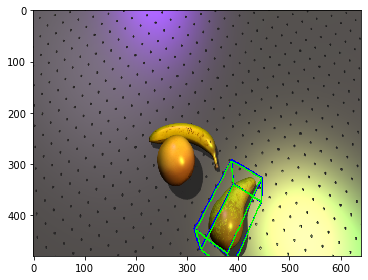

Prediction Accuracy - MAE: 1.6, MSE 3.59


In [92]:
yPred = cv2.projectPoints(pts3d2, rVec, tVec, matrix, np.zeros(shape=[8, 1], dtype='float64'))[0]
yPred = np.squeeze(yPred)

# yTrue = data.labelFloatsToPixels(labels, decPlace = 8)[:8] # converting our labels to pixel values #####[1::]
pose = np.load(f'/home/mahmoud/stvNet/LINEMOD/{class_name}/pose/{int(img_id[0])}.npy')
rVec_True = np.array(pose[0:3, 0:3], dtype='float64')
tVec_True = np.array(pose[0:3, 3], dtype='float64')

yTrue = cv2.projectPoints(pts3d2, rVec_True, tVec_True, matrix, np.zeros(shape=[8, 1], dtype='float64'))[0]
yTrue = np.squeeze(yTrue)

print("Keypoint pixel predictions: " + str(yPred))
print("Keypoint ground truth: " + str(yTrue))


def labelDrawPoints(drawList): # (b, f = back, front), (l, r = left, right), (u, d = up , down)
	drawDict = {}
	drawDict['bld'] = (int(round(drawList[0][0])), int(round(drawList[0][1])))
	drawDict['blu'] = (int(round(drawList[1][0])), int(round(drawList[1][1])))
	drawDict['fld'] = (int(round(drawList[2][0])), int(round(drawList[2][1])))
	drawDict['flu'] = (int(round(drawList[3][0])), int(round(drawList[3][1])))
	drawDict['brd'] = (int(round(drawList[4][0])), int(round(drawList[4][1])))
	drawDict['bru'] = (int(round(drawList[5][0])), int(round(drawList[5][1])))
	drawDict['frd'] = (int(round(drawList[6][0])), int(round(drawList[6][1])))
	drawDict['fru'] = (int(round(drawList[7][0])), int(round(drawList[7][1])))
	return drawDict

def drawPose(img, drawPoints, colour = (255,0,0)): # draw bounding box
	
	cv2.line(img, drawPoints['bld'], drawPoints['blu'], colour, 2)
	cv2.line(img, drawPoints['bld'], drawPoints['fld'], colour, 2)
	cv2.line(img, drawPoints['bld'], drawPoints['brd'], colour, 2)
	cv2.line(img, drawPoints['blu'], drawPoints['flu'], colour, 2)
	cv2.line(img, drawPoints['blu'], drawPoints['bru'], colour, 2)
	cv2.line(img, drawPoints['fld'], drawPoints['flu'], colour, 2)
	cv2.line(img, drawPoints['fld'], drawPoints['frd'], colour, 2)
	cv2.line(img, drawPoints['flu'], drawPoints['fru'], colour, 2)
	cv2.line(img, drawPoints['fru'], drawPoints['bru'], colour, 2)
	cv2.line(img, drawPoints['fru'], drawPoints['frd'], colour, 2)
	cv2.line(img, drawPoints['frd'], drawPoints['brd'], colour, 2)
	cv2.line(img, drawPoints['brd'], drawPoints['bru'], colour, 2)

img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

drawPose(img, labelDrawPoints(yPred)) #  drawing our predicted bounding box in blue
drawPose(img, labelDrawPoints(yTrue), (0,255,0)) # drawing the true bounding box in green
showImage(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

print("Prediction Accuracy - MAE: {0}, MSE {1}".format(round(tf.reduce_mean(tf.keras.metrics.mean_absolute_error(yTrue, yPred)).numpy(), 2), round(tf.reduce_mean(tf.keras.metrics.mean_squared_error(yTrue, yPred)).numpy(), 2)))

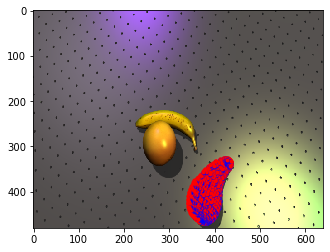

In [83]:
from test_vis import test_res
from plyfile import PlyData

pose = np.load(f'/home/mahmoud/stvNet/LINEMOD/{class_name}/pose/{int(img_id[0])}.npy')
pc = f'/home/mahmoud/stvNet/LINEMOD/{class_name}/{class_name}.ply'

plydata = PlyData.read(pc)
elm = plydata.elements
data = np.asarray(elm[0][:])

res_pc = np.zeros((len(data), 3))

for i in range(len(data)):
    res_pc[i][0], res_pc[i][1], res_pc[i][2] = data[i][0], data[i][1], data[i][2]


test_res(image, res_pc, pose, rVec, tVec, matrix)

## Evaluation methods

- Evaluate PVNet method using two common metrics: 
    - 2D projection metric.
    - Average 3D distance of model points (ADD) metric.
    
- **2D Projection metric**: 
    - Computes the mean distance between the projections of 3D model points given the estimated and the ground truth pose. 
    - A pose is considered as correct if the distance is less than **5 pixels**.

- **ADD metric**: 
    - Transform the model points by the estimated and the ground truth poses, respectively.
    - Compute the mean distance between the two transformed point sets. 
    - When the distance is less than **10% of the model’s diameter**, it is claimed that the estimated pose is correct.


In [93]:
def transform_pts_Rt(pts, R, t):
  """Applies a rigid transformation to 3D points.
  :param pts: nx3 ndarray with 3D points.
  :param R: 3x3 ndarray with a rotation matrix.
  :param t: 3x1 ndarray with a translation vector.
  :return: nx3 ndarray with transformed 3D points.
  """
  assert (pts.shape[1] == 3)
  pts_t = R.dot(pts.T) + t.reshape((3, 1))
  return pts_t.T

def project_pts(pts, K, R, t):
  """Projects 3D points.
  :param pts: nx3 ndarray with the 3D points.
  :param K: 3x3 ndarray with an intrinsic camera matrix.
  :param R: 3x3 ndarray with a rotation matrix.
  :param t: 3x1 ndarray with a translation vector.
  :return: nx2 ndarray with 2D image coordinates of the projections.
  """
  assert (pts.shape[1] == 3)
  P = K.dot(np.hstack((R, t)))
  pts_h = np.hstack((pts, np.ones((pts.shape[0], 1))))
  pts_im = P.dot(pts_h.T)
  pts_im /= pts_im[2, :]
  return pts_im[:2, :].T


def add(R_est, t_est, R_gt, t_gt, pts):
  """Average Distance of Model Points for objects with no indistinguishable
  views - by Hinterstoisser et al. (ACCV'12).
  :param R_est: 3x3 ndarray with the estimated rotation matrix.
  :param t_est: 3x1 ndarray with the estimated translation vector.
  :param R_gt: 3x3 ndarray with the ground-truth rotation matrix.
  :param t_gt: 3x1 ndarray with the ground-truth translation vector.
  :param pts: nx3 ndarray with 3D model points.
  :return: The calculated error.
  """
  pts_est = transform_pts_Rt(pts, R_est, t_est)
  pts_gt = transform_pts_Rt(pts, R_gt, t_gt)
  e = np.linalg.norm(pts_est - pts_gt, axis=1).mean()
  return e

def re(R_est, R_gt):
  """Rotational Error.
  :param R_est: 3x3 ndarray with the estimated rotation matrix.
  :param R_gt: 3x3 ndarray with the ground-truth rotation matrix.
  :return: The calculated error.
  """
  error_cos = float(0.5 * (np.trace(R_est.dot(np.linalg.inv(R_gt))) - 1.0))

  # Avoid invalid values due to numerical errors.
  error_cos = min(1.0, max(-1.0, error_cos))

  error = math.acos(error_cos)
  error = 180.0 * error / np.pi  # Convert [rad] to [deg].
  return error


def te(t_est, t_gt):
  """Translational Error.
  :param t_est: 3x1 ndarray with the estimated translation vector.
  :param t_gt: 3x1 ndarray with the ground-truth translation vector.
  :return: The calculated error.
  """
  assert (t_est.size == t_gt.size == 3)
  error = np.linalg.norm(t_gt - t_est)
  return error


def proj(R_est, t_est, R_gt, t_gt, K, pts):
  """Average distance of projections of object model vertices [px]
  - by Brachmann et al. (CVPR'16).
  :param R_est: 3x3 ndarray with the estimated rotation matrix.
  :param t_est: 3x1 ndarray with the estimated translation vector.
  :param R_gt: 3x3 ndarray with the ground-truth rotation matrix.
  :param t_gt: 3x1 ndarray with the ground-truth translation vector.
  :param K: 3x3 ndarray with an intrinsic camera matrix.
  :param pts: nx3 ndarray with 3D model points.
  :return: The calculated error.
  """
  proj_est = project_pts(pts, K, R_est, t_est)
  proj_gt = project_pts(pts, K, R_gt, t_gt)
  e = np.linalg.norm(proj_est - proj_gt, axis=1).mean()
  return e


def cou_mask(mask_est, mask_gt):
  """Complement over Union of 2D binary masks.
  :param mask_est: hxw ndarray with the estimated mask.
  :param mask_gt: hxw ndarray with the ground-truth mask.
  :return: The calculated error.
  """
  mask_est_bool = mask_est.astype(bool)
  mask_gt_bool = mask_gt.astype(bool)

  inter = np.logical_and(mask_gt_bool, mask_est_bool)
  union = np.logical_or(mask_gt_bool, mask_est_bool)

  union_count = float(union.sum())
  if union_count > 0:
    e = 1.0 - inter.sum() / union_count
  else:
    e = 1.0
  return e


In [95]:
def read_3d_points_linemod(object_name):
    filename = f'LINEMOD/{object_name}/{object_name}.ply'
    with open(filename) as f:
        in_vertex_list = False
        vertices = []
        in_mm = False
        for line in f:
            if in_vertex_list:
                vertex = line.split()[:3]
                vertex = np.array([float(vertex[0]),
                                   float(vertex[1]),
                                   float(vertex[2])], dtype=np.float32)
                if in_mm:
                    vertex = vertex / np.float32(10) # mm -> cm
                vertex = vertex / np.float32(100)
                vertices.append(vertex)
                if len(vertices) >= vertex_count:
                    break
            elif line.startswith('element vertex'):
                vertex_count = int(line.split()[-1])
            elif line.startswith('end_header'):
                in_vertex_list = True
            elif line.startswith('element face'):
                in_mm = True
    return np.matrix(vertices)

In [94]:
def read_diameter(object_name):
    # this is the same for linemod and occlusion linemod
    
    filename = f'/home/mahmoud/stvNet/LINEMOD/{object_name}/diameter.txt'
    with open(filename) as f:
        diameter_in_cm = float(f.readline())
    return diameter_in_cm * 0.01


In [96]:
# record = np.load(args.prediction_file, allow_pickle=True).item()
# pts3d = read_3d_points_linemod(class_name)

diameter = read_diameter(class_name)
print(diameter)

0.12950802


In [99]:
# Read Pose of the image 
# Change Pose number based on the number of image

pose = np.load(f'/home/mahmoud/stvNet/LINEMOD/{class_name}/pose/{int(img_id[0])}.npy')
rVec_gt = np.array(pose[0:3, 0:3], dtype='float64')
tVec_gt = np.array(pose[0:3, 3], dtype='float64')


In [100]:
tVec_gt.shape
tVec_gt =tVec_gt.reshape(3,1)
tVec_gt.shape

(3, 1)

In [123]:
rVec_gt.shape

(3, 3)

In [126]:
# Comvert from vector to matrix 
# src = 3*1
# cv2.Rodrigues2(rVec, rVec2, jacobian=0)
from scipy.spatial.transform import Rotation as R

r = R.from_rotvec(rVec.reshape(3,))
rVec_est = np.array(r.as_matrix())
rVec_est.shape

(3, 3)

## Evaluation result

In [132]:
add(rVec_est, tVec, rVec_gt, tVec_gt, pts3d)

0.011708668854770895

In [133]:
add(rVec_est, tVec, rVec_gt, tVec_gt, pts3d)< diameter*0.1

True

In [134]:
proj(rVec_est, tVec, rVec_gt, tVec_gt, matrix, pts3d)

2.4777170427258417

In [135]:
proj(rVec_est, tVec, rVec_gt, tVec_gt, matrix, pts3d)< 5

True

In [136]:
cou_mask(classPred, mask)

0.9751418182767693

---

## Keypoint Selection
* Select **k** keypoint using FPS algorithm
1. Initialize keypoint set by adding the object center.
2. Repeatedly find a point on object surface farthest to current keypoint set.
3. Add this point to the set until the size of the set = k

## Multiple instances
- PVNet method can handle multiple instances.
1. For each object class, we generate the hypotheses of the object centers and their voting scores using our proposed voting scheme. 
2. Then,find the modes among the hypotheses and mark these modes as centers of different instances. 
3. Finally, the instance masks are obtained by assigning pixels to the nearest instance center they vote for.

## Symmetric objects
* There are ambiguities of keypoint locations. 
* To eliminate the ambiguities, rotate the symmetric object to a canonical pose during training, as suggested by [**Bb8:** A scalable, accurate, robust to partial occlusion method for predicting the 3d poses of]

## Conclusion

This gives us our final output values for this process, and can be used to generated a number of accuracy metrics, as well as the photo rendered above which gives a visual representation of the accuracy of the process.